# Imports

In [72]:
import cv2
import torch
import pathlib
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from PIL import Image
from tqdm.auto import tqdm
from torchinfo import summary
from torchvision import models
from tqdm.notebook import tqdm
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

# Preprocessing

# Datasets

In [73]:
class DroneDataset(Dataset):

    def __init__(self, path, albumentations):
        self.img_paths = list(pathlib.Path(f"{path}/img").glob("*.jpg"))
        self.mask_paths = list(pathlib.Path(f"{path}/mask").glob("*.png"))
        self.albumentations = albumentations
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, i):
        img = cv2.imread(str(self.img_paths[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.mask_paths[i]), cv2.IMREAD_GRAYSCALE)
        a = self.albumentations(image=img, mask=mask)
        img = Image.fromarray(a['image'])
        img = T.ToTensor()(img)
        mask = a['mask']
        mask = torch.from_numpy(mask).long()

        return img, mask

In [74]:
t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)

#datasets
train_set = DroneDataset("./data/drone-dataset/train", t_train)
val_set = DroneDataset("./data/drone-dataset/val", t_val)
test_set = DroneDataset("./data/drone-dataset/test", t_test)

train_loader = DataLoader(train_set, batch_size=3, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=3, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=3, shuffle=True, drop_last=True)

# Model

In [75]:
class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, dilation, bias, activation=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride,
                              padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.activation = activation
        if self.activation:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        if self.activation:
            outputs = self.relu(x)
        else:
            outputs = x

        return outputs

In [76]:
class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
          param.requires_grad = False

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        auxiliary_x = self.resnet.layer1(x)
        x = self.resnet.layer2(auxiliary_x)
        #auxiliary_x = self.resnet.layer3(x)
        #x = self.resnet.layer4(auxiliary_x)

        return x, auxiliary_x

In [77]:
class PyramidPoolingModule(nn.Module):

    def __init__(self, pools, in_channels, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.pooling_layers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=p), # Pool
                conv2DBatchNorm(in_channels, int(in_channels / len(pools)), kernel_size=1, stride=1, padding=0, dilation=1, bias=False, activation=True) # Conv
            )
            for p in pools
        ])

    def forward(self, x):
        outputs = [x]
        for pooling_layer in self.pooling_layers:
            layer_output = pooling_layer(x)
            outputs.append(F.interpolate(layer_output, size=self.input_shape, mode="bilinear", align_corners=True))

        return torch.cat(outputs, dim=1)

In [78]:
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super().__init__()

        self.height = height
        self.width = width

        self.cbr = conv2DBatchNorm(
            in_channels=1024, out_channels=64, kernel_size=3, stride=1,
            padding=1, dilation=1,  bias=False, activation=True)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=64, out_channels=n_classes, kernel_size=1,
            stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width),
            mode='bilinear', align_corners=True)

        return output

In [79]:
class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        full_img_size = 256
        feature_map_size = 32

        self.feature_extractor = CustomResNet()
        self.pyramid_pooling = PyramidPoolingModule(input_shape=(32, 32), in_channels=512, pools = (6, 3, 2, 1))
        self.decode_feature = DecodePSPFeature(height=full_img_size, width=full_img_size,n_classes=n_classes)

    def forward(self, x):
        encoder_outputs, encoder_auxiliary = self.feature_extractor(x)
        pyramid_outputs = self.pyramid_pooling(encoder_outputs)
        decoder_outputs = self.decode_feature(pyramid_outputs)
        return decoder_outputs

In [80]:
model = PSPNet(n_classes=23)
summary(model, input_size=(3, 3, 256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
PSPNet                                             [3, 23, 256, 256]         --
├─CustomResNet: 1-1                                [3, 512, 32, 32]          --
│    └─ResNet: 2-1                                 --                        24,112,104
│    │    └─Conv2d: 3-1                            [3, 64, 128, 128]         (9,408)
│    │    └─BatchNorm2d: 3-2                       [3, 64, 128, 128]         (128)
│    │    └─ReLU: 3-3                              [3, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                         [3, 64, 64, 64]           --
│    │    └─Sequential: 3-5                        [3, 256, 64, 64]          (215,808)
│    │    └─Sequential: 3-6                        [3, 512, 32, 32]          (1,219,584)
├─PyramidPoolingModule: 1-2                        [3, 1024, 32, 32]         --
│    └─ModuleList: 2-2                             --                        --
│  

# Training

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [87]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    model.to(device)
    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for i, (img, mask) in enumerate(train_loader):
            img = img.to(device)
            mask = mask.to(device)
            output = model(img)
            loss = criterion(output, mask)
            train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.inference_mode():
            for i, (img, mask) in enumerate(val_loader):
                img = img.to(device)
                mask = mask.to(device)
                output = model(img)
                loss = criterion(output, mask)
                val_loss += loss
            
        print(f"Epoch {e} | Loss: {train_loss/len(train_loader)} | Val Loss: {val_loss/len(val_loader)}")

In [96]:
fit(25, model, train_loader, val_loader, criterion, optimizer)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.9859318137168884 | Val Loss: 0.7583021521568298
Epoch 1 | Loss: 0.9678024053573608 | Val Loss: 0.7522590756416321
Epoch 2 | Loss: 0.935411274433136 | Val Loss: 0.7419086694717407
Epoch 3 | Loss: 0.9128113389015198 | Val Loss: 0.701083779335022
Epoch 4 | Loss: 0.8722374439239502 | Val Loss: 0.7488873600959778
Epoch 5 | Loss: 0.8653481006622314 | Val Loss: 0.690104067325592
Epoch 6 | Loss: 0.8721808195114136 | Val Loss: 0.6576892733573914
Epoch 7 | Loss: 0.8516760468482971 | Val Loss: 0.6886945366859436
Epoch 8 | Loss: 0.8207924365997314 | Val Loss: 0.6728659868240356
Epoch 9 | Loss: 0.8331007361412048 | Val Loss: 0.6787700653076172
Epoch 10 | Loss: 0.7883539795875549 | Val Loss: 0.6340293288230896
Epoch 11 | Loss: 0.8040353655815125 | Val Loss: 0.6988479495048523
Epoch 12 | Loss: 0.7988980412483215 | Val Loss: 1.1362806558609009
Epoch 13 | Loss: 0.8002173900604248 | Val Loss: 0.9688615798950195
Epoch 14 | Loss: 0.79824298620224 | Val Loss: 0.650888204574585
Epoch 15 | 

# Evaluation

## Result

In [89]:
def predict_image_mask(model, image):
    model.eval()
    model.to(device)
    image = image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

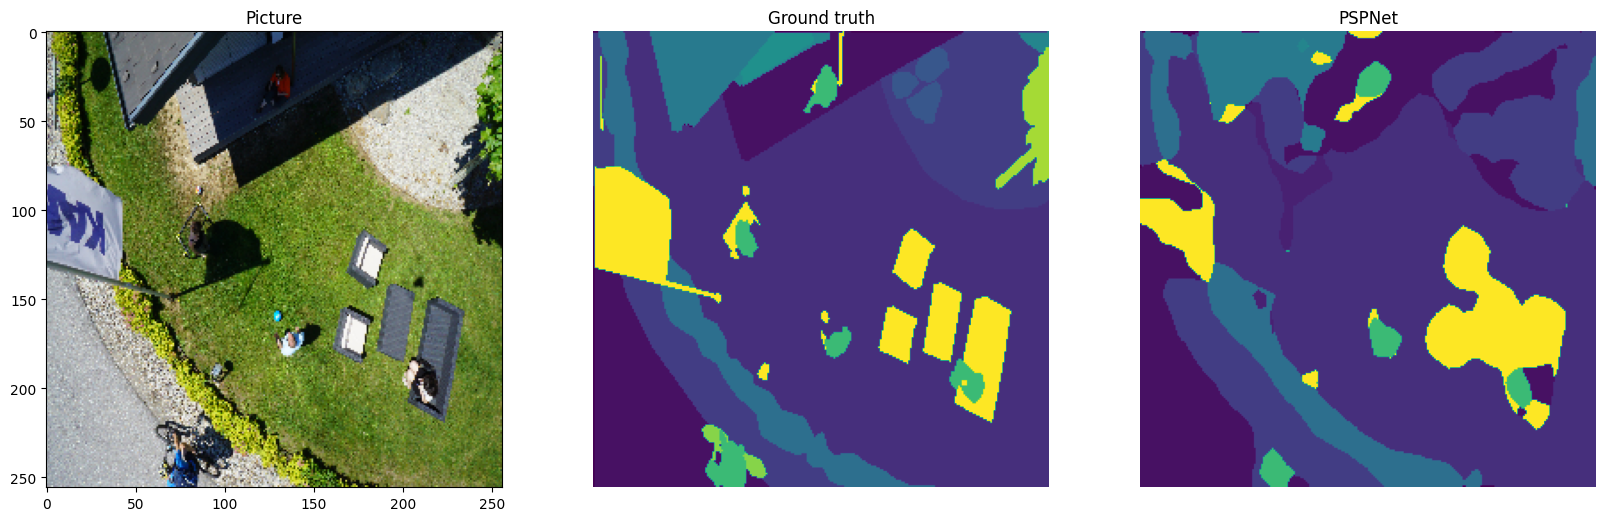

In [105]:
image, mask = test_set[33]
pred_mask = predict_image_mask(model, image)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(T.ToPILImage()(image))
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('PSPNet')
ax3.set_axis_off()